Manifold learning parte 2/2 (isomap)
---

Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co

jariasg@uniquindio.edu.co

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

<ipython-input-3-cd9e54b682e8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Isomap en Rostros

Un lugar donde se utiliza el aprendizaje de variedades es en comprender la relación entre puntos de datos de alta dimensión.
Un caso común de datos de alta dimensión son las imágenes. por ejemplo, un conjunto de imágenes con 1,000 píxeles cada una se puede pensar como una colección de puntos en 1,000 dimensiones, con el brillo de cada píxel en cada imagen definiendo la coordenada en esa dimensión.

Para ilustrar, apliquemos Isomap en algunos datos del conjunto de datos de Rostros Etiquetados en la Naturaleza como Máquinas de Vectores de Soporte y Análisis de Componentes Principales.

Al ejecutar este comando, se descargará el conjunto de datos y se almacenará en caché en su directorio de inicio para su uso posterior:

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.target_names)
print(faces.images.shape)
print(faces.data.shape)

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']
(2370, 62, 47)
(2370, 2914)


Tenemos 2,370 imágenes, cada una con 2,914 píxeles. ¡En otras palabras, las imágenes se pueden considerar como puntos de datos en un espacio de 2,914 dimensiones!

Veamos varias de estas imágenes:

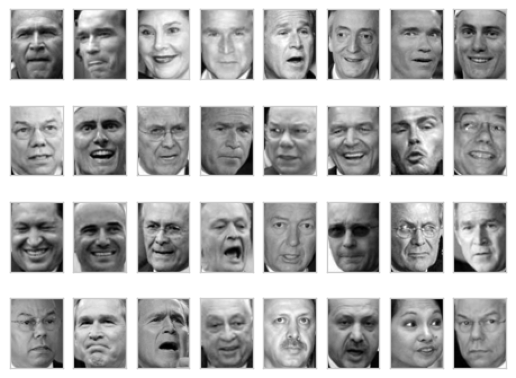

In [4]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Cuando nos encontramos con estos datos en Análisis de Componentes Principales, nuestro objetivo era básicamente la compresión: usar los componentes para reconstruir las entradas a partir de la representación de menor dimensión.

El PCA es lo suficientemente versátil como para que también lo podamos utilizar en este contexto, donde nos gustaría trazar un embedding de baja dimensión de los datos de 2,914 dimensiones para aprender las relaciones fundamentales entre las imágenes.

Veamos nuevamente la proporción de varianza explicada, lo cual nos dará una idea de cuántas características lineales son necesarias para describir los datos:

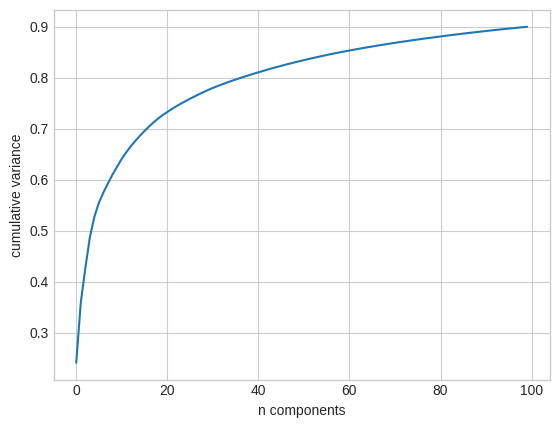

In [5]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Vemos que para estos datos, se requieren casi 100 componentes para preservar el 90% de la varianza. Esto nos dice que los datos son intrínsecamente de alta dimensionalidad, no se pueden describir linealmente con solo unos pocos componentes.

Cuando esto sucede, embeddings no lineales en manifolds como LLE e Isomap pueden ser útiles. Podemos calcular un embedding de Isomap en estas caras utilizando el mismo patrón mostrado anteriormente:

In [6]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

La salida es una proyección bidimensional de todas las imágenes de entrada.

Para tener una mejor idea de lo que nos dice la proyección, definamos una función que generará miniaturas de imágenes en las ubicaciones de las proyecciones:

In [7]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Al llamar a esta función ahora, vemos el resultado en la siguiente figura:

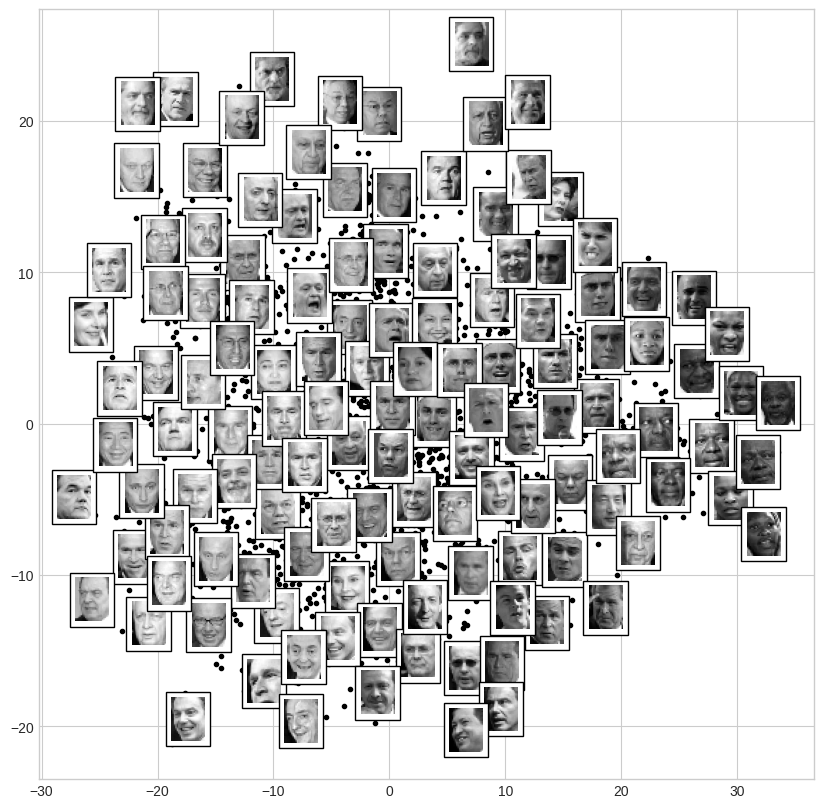

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

El resultado es interesante. Las dos primeras dimensiones de Isomap parecen describir características globales de la imagen: el brillo general de la imagen de izquierda a derecha y la orientación general de la cara de abajo hacia arriba. Esto nos da una buena indicación visual de algunas de las características fundamentales de nuestros datos.

A partir de aquí, podríamos pasar a clasificar estos datos (quizás utilizando múltiples características como entradas para el algoritmo de clasificación)

## Ejemplo: visualización de estructura en dígitos
Como otro ejemplo del uso del aprendizaje múltiple para la visualización, echemos un vistazo al conjunto de datos de dígitos escritos a mano de MNIST.


In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)

El conjunto de datos consta de 70.000 imágenes, cada una con 784 píxeles (es decir, las imágenes son de 28 × 28).

Como antes, podemos echar un vistazo a las primeras imágenes:

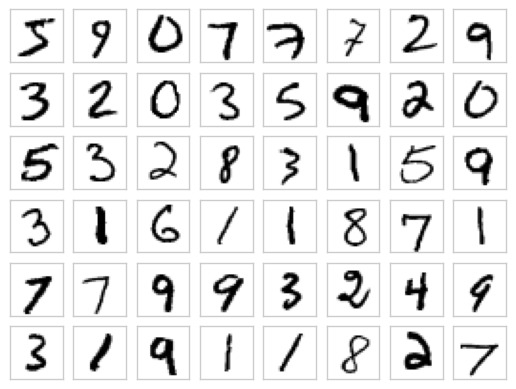

In [10]:
mnist_data = np.asarray(mnist.data)
mnist_target = np.asarray(mnist.target, dtype=int)

fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist_data[1250 * i].reshape(28, 28), cmap='gray_r')

Esto nos da una idea de la variedad de estilos de escritura a mano en el conjunto de datos.

Calculemos una proyección de aprendizaje múltiple a través de los datos. Para la velocidad aquí, solo usaremos 1/30 de los datos, que son aproximadamente ~2000 puntos (debido a la escala relativamente pobre del aprendizaje múltiple, encuentro que unos pocos miles de muestras es un buen número para comenzar para procesos relativamente rápidos).

<ipython-input-11-a1094fae6048>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))


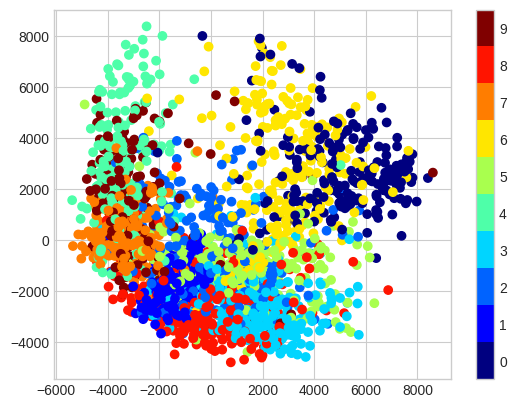

In [11]:
# Use only 1/30 of the data: full dataset takes a long time!
data = mnist_data[::30]
target = mnist_target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

El diagrama de dispersión resultante muestra algunas de las relaciones entre los puntos de datos, pero está un poco abarrotado.
Podemos obtener más información observando un solo número a la vez:

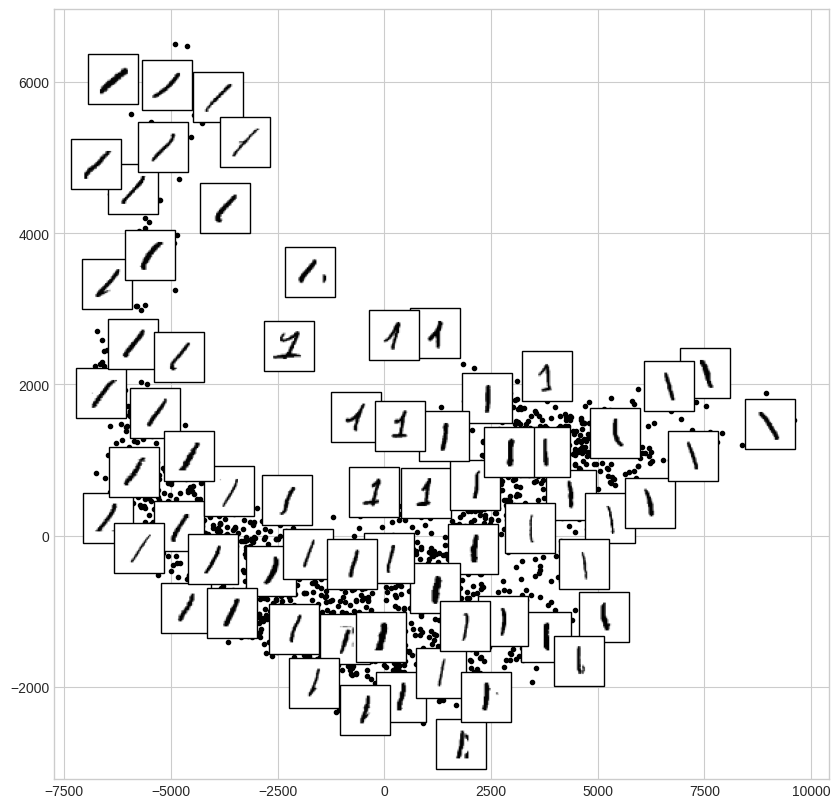

In [12]:
# Choose 1/4 of the "1" digits to project
data = mnist_data[mnist_target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

El resultado le da una idea de la variedad de formas que puede adoptar el número 1 dentro del conjunto de datos. Los datos se encuentran a lo largo de una amplia curva en el espacio proyectado, que parece trazar la orientación del dígito.

A medida que avanza en la gráfica, encontrará 1 que tienen sombreros y/o bases, aunque estos son muy escasos dentro del conjunto de datos. La proyección nos permite identificar valores atípicos que tienen problemas de datos: por ejemplo, partes de los dígitos vecinos que se colaron en las imágenes extraídas.

Ahora bien, esto en sí mismo puede no ser útil para la tarea de clasificar dígitos, pero nos ayuda a comprender los datos y puede darnos ideas sobre cómo avanzar, por ejemplo, cómo podríamos querer preprocesar los datos antes. construir un canal de clasificación.